In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import gensim

import scikitplot.plotters as skplt

import nltk

from xgboost import XGBClassifier

import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

In [3]:
import os 
os.getcwd()

'/home/cesar/Documents/ML_bootcamp2021/msk-redefining-cancer-treatment'

In [6]:
df_train_txt = pd.read_csv('training_text.csv', sep='\|\|', engine='python',  header=None, skiprows=1, names=["ID","Text"])
df_train_txt.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [7]:
df_train_var = pd.read_csv('training_variants.csv')
df_train_var.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [8]:
df_test_txt = pd.read_csv('test_text.csv', sep='\|\|', engine='python', header=None, skiprows=1, names=["ID","Text"])
df_test_txt.head()

,ID,Text
0,"ID,Text",None
1,0,2. This mutation resulted in a myeloproliferat...
2,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
3,2,Vascular endothelial growth factor receptor (V...
4,3,Inflammatory myofibroblastic tumor (IMT) is a ...


In [10]:
### Remember that in previous read.csv, had to add engine='python',
### otherwise it treats like an error, though didn't seem a big error,
## not enough to stop the program, but I didn't want to play with that

In [11]:
df_test_var = pd.read_csv('test_variants.csv')
df_test_var.head()

,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A


In [12]:
df_train = pd.merge(df_train_var, df_train_txt, how='left', on='ID')
df_train.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [17]:
df_test = pd.concat([df_test_var, df_test_txt], axis=1)
df_test.head()

,ID,Gene,Variation,ID,Text
0,0.0,ACSL4,R570S,"ID,Text",None
1,1.0,NAGLU,P521L,0,2. This mutation resulted in a myeloproliferat...
2,2.0,PAH,L333F,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
3,3.0,ING1,A148D,2,Vascular endothelial growth factor receptor (V...
4,4.0,TMEM216,G77A,3,Inflammatory myofibroblastic tumor (IMT) is a ...


In [18]:
df_train.describe(include='all')

,ID,Gene,Variation,Class,Text
count,3321.000000,3321,3321,3321.000000,3316
unique,NaN,264,2996,NaN,1920
top,NaN,BRCA1,Truncating Mutations,NaN,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,264,93,NaN,53
mean,1660.000000,NaN,NaN,4.365854,NaN
std,958.834449,NaN,NaN,2.309781,NaN
min,0.000000,NaN,NaN,1.000000,NaN
25%,830.000000,NaN,NaN,2.000000,NaN
50%,1660.000000,NaN,NaN,4.000000,NaN
75%,2490.000000,NaN,NaN,7.000000,NaN


In [19]:
df_test.describe(include='all')

,ID,Gene,Variation,ID,Text
count,5668.000000,5668,5668,5669,5667
unique,NaN,1397,5628,5669,5610
top,NaN,F8,Truncating Mutations,4981,Mutations in BRCA1 and BRCA2 account for the m...
freq,NaN,134,18,1,6
mean,2833.500000,NaN,NaN,NaN,NaN
std,1636.354994,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN,NaN
25%,1416.750000,NaN,NaN,NaN,NaN
50%,2833.500000,NaN,NaN,NaN,NaN
75%,4250.250000,NaN,NaN,NaN,NaN


<AxesSubplot:>

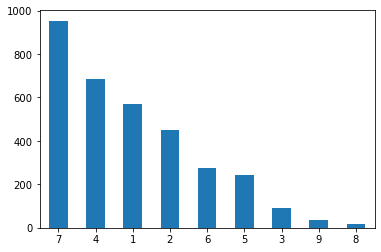

In [20]:
df_train['Class'].value_counts().plot(kind="bar", rot=0)

In [32]:
def evaluate_features(X, y, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf = LogisticRegression()
    
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(shuffle=True, random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    skplt.plot_confusion_matrix(y, preds)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s


Log loss: 0.13824294144096805
Accuracy: 0.9666666666666667


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
/home/cesar/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


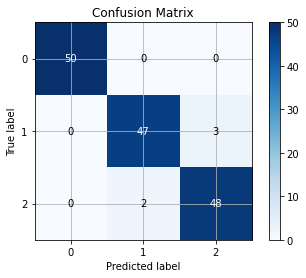

In [33]:
from sklearn.datasets import load_iris
evaluate_features(*load_iris(True)) ## I worry about this one later

In [34]:
import nltk
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)

In [35]:
bag_of_words = count_vectorizer.fit_transform(df_train['Text'])
len(count_vectorizer.get_feature_names())

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/home/cesar/nltk_data'
    - '/home/cesar/anaconda3/nltk_data'
    - '/home/cesar/anaconda3/share/nltk_data'
    - '/home/cesar/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************
